# Resampling

In [1]:
from satpy import Scene
from glob import glob
from pyresample import create_area_def
from pyresample import load_area
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

/home/xin/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load data

In [2]:
f_abi = glob('../data/abi/OR_ABI-L1b*s20221822100*.nc')
scn_abi = Scene(f_abi, reader='abi_l1b')
scn_abi.load(['C01'])

f_tropomi = glob('../data/tropomi/S5P_NRTI_L2__CO_____20220701T2041*.nc')
scn_tropomi = Scene(f_tropomi, reader='tropomi_l2')
scn_tropomi.load(['assembled_lon_bounds', 'assembled_lat_bounds','carbonmonoxide_total_column'])

# f_tropomi = glob('../data/tropomi/S5P_NRTI_L2__NO2____20220701T204117*.nc')
# scn_tropomi.load(['assembled_lon_bounds', 'assembled_lat_bounds','nitrogendioxide_tropospheric_column'])

## Rectilinear grids

In [3]:
# from pyresample.geometry import GridDefinition

# lons = np.arange(-165, -139.99, 0.01)
# lats = np.arange(60, 70.01, 0.01)
# lons, lats = np.meshgrid(lons, lats)
# alaska_rect = GridDefinition(lons=lons, lats=lats)

In [4]:
# define the interested area
alaska_rect = create_area_def('alaska_Rectilinear',
                              {'proj': 'longlat', 'datum': 'WGS84'},
                              area_extent=[-165, 60, -140, 70],
                              resolution=0.01,
                              units='degrees',
                              description='Alaska 0.01x0.01 degree lat-lon grid')

In [5]:
alaska_rect

/home/xin/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Area ID: alaska_Rectilinear
Description: Alaska 0.01x0.01 degree lat-lon grid
Projection: {'datum': 'WGS84', 'no_defs': 'None', 'proj': 'longlat', 'type': 'crs'}
Number of columns: 2500
Number of rows: 1000
Area extent: (-165.0, 60.0, -140.0, 70.0)

/home/xin/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/xin/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


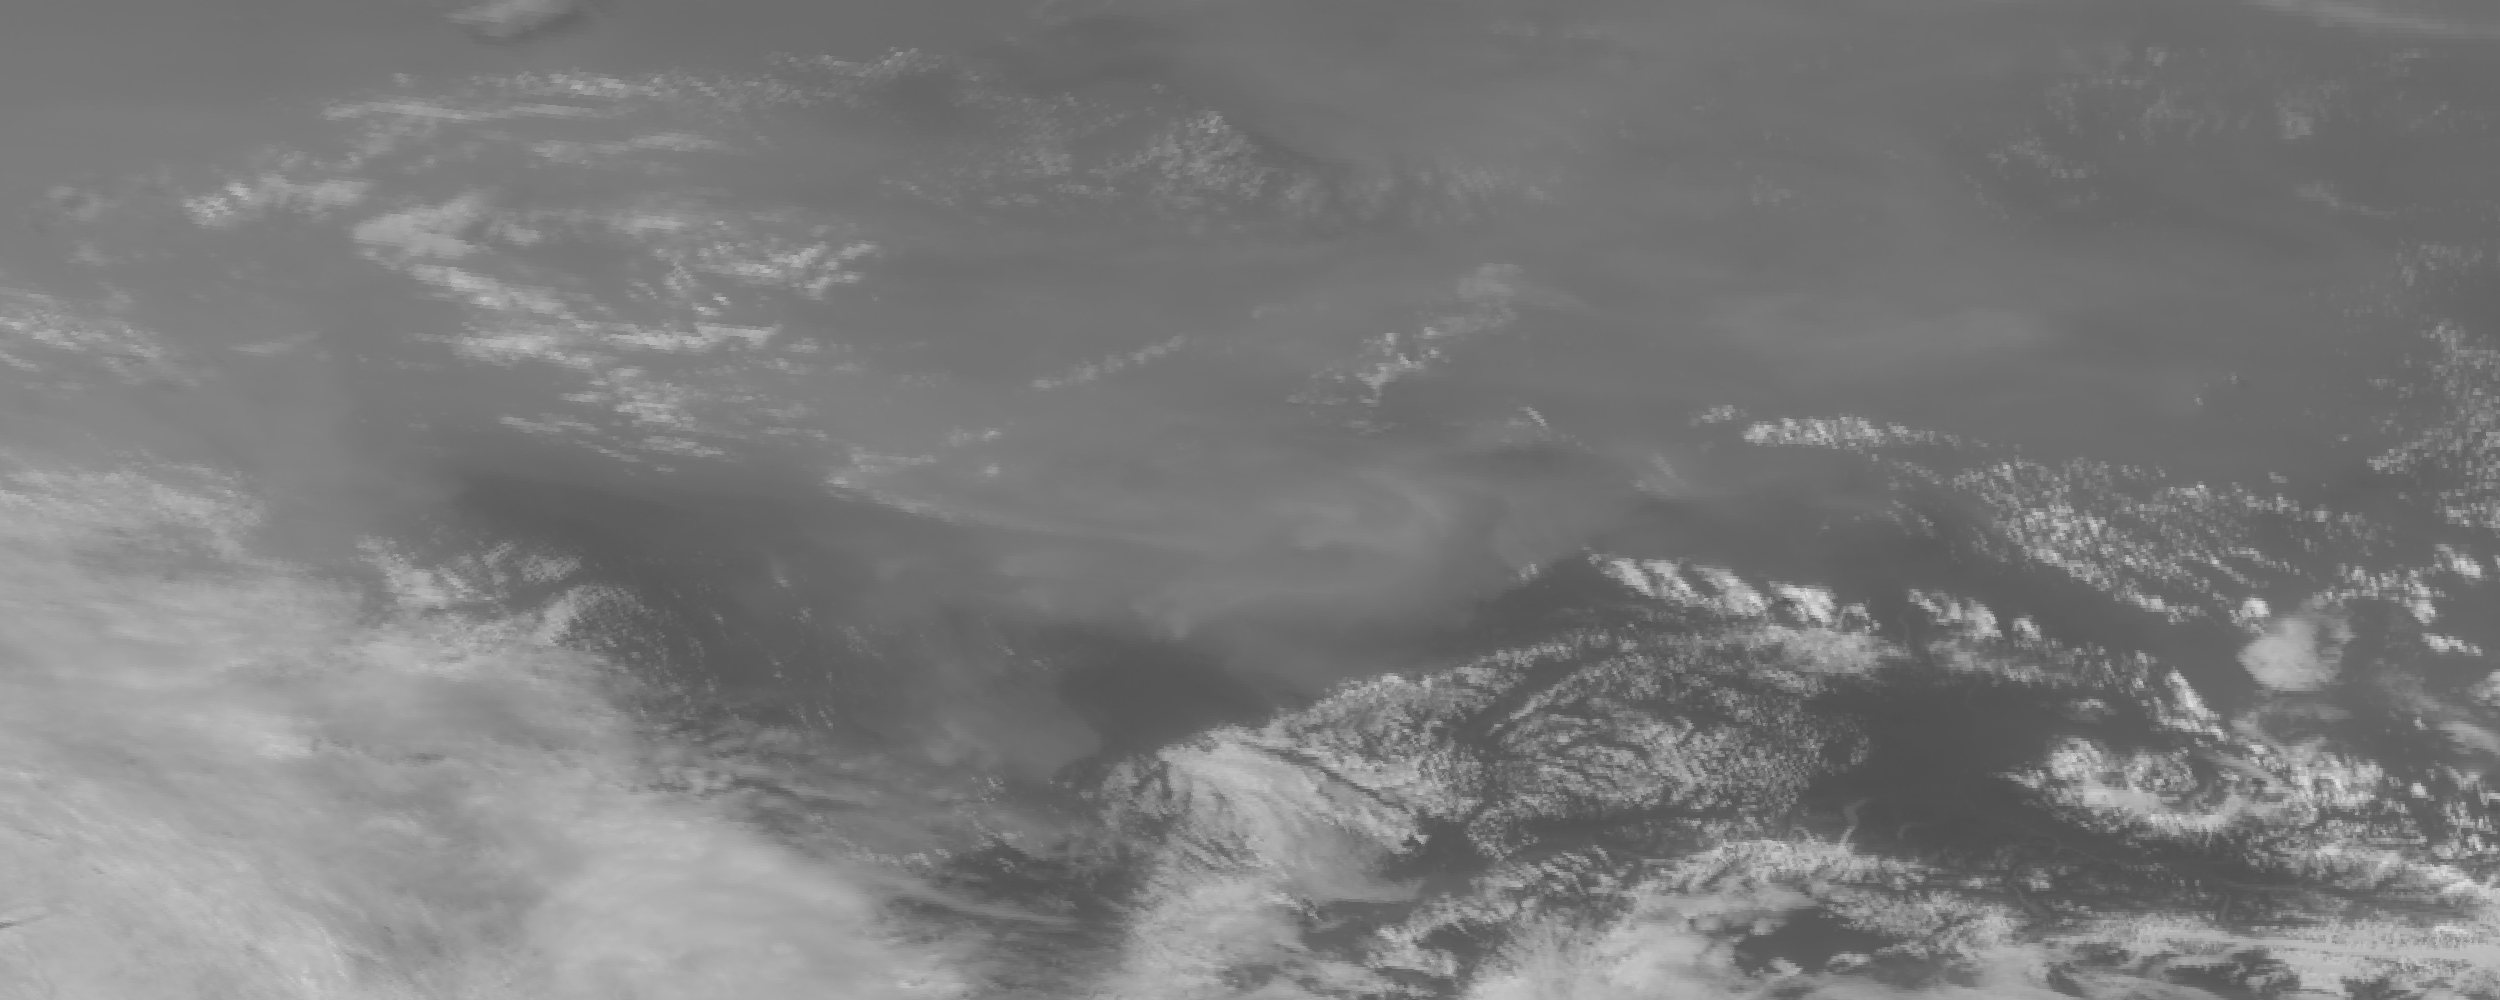

In [6]:
scn_abi_alaska_rect = scn_abi.resample(alaska_rect)
scn_abi_alaska_rect.show('C01')

In [7]:
# delete ancillary_variables in case of bug in EWA resampler
#   https://github.com/pytroll/pyresample/issues/440
scn_tropomi['carbonmonoxide_total_column'].attrs['ancillary_variables'] = []

In [8]:
scn_tropomi_alaska_rect = scn_tropomi.resample(alaska_rect)
# scn_tropomi_alaska_rect = scn_tropomi.resample(alaska_rect, resampler='ewa', rows_per_scan=scn_tropomi['carbonmonoxide_total_column'].shape[0])

Text(0.5, 1.0, '0.01 deg x 0.01 deg (nearest)')

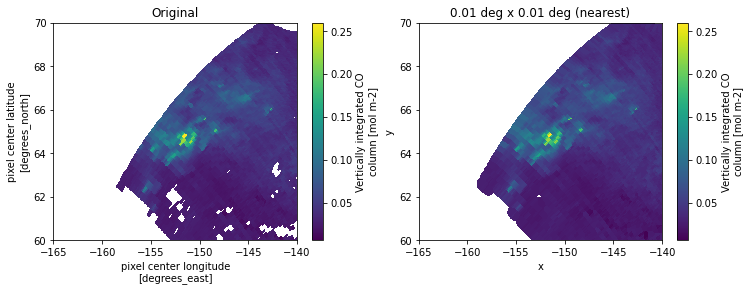

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

scn_tropomi['carbonmonoxide_total_column'].plot(ax=axs[0], x='longitude', y='latitude', xlim=(-165, -140), ylim=(60, 70))
scn_tropomi_alaska_rect['carbonmonoxide_total_column'].plot(ax=axs[1], xlim=(-165, -140), ylim=(60, 70))

axs[0].set_title('Original')
axs[1].set_title('0.01 deg x 0.01 deg (nearest)')

## Alternative: xESMF conservative regridder

In [10]:
ds_tropomi = scn_tropomi.to_xarray_dataset()
ds_tropomi = ds_tropomi.rename({'longitude': 'lon', 'latitude': 'lat'})
ds_tropomi.coords['lon_b'] = scn_tropomi['assembled_lon_bounds'].rename({'y_bounds': 'y_b', 'x_bounds': 'x_b'})
ds_tropomi.coords['lat_b'] = scn_tropomi['assembled_lat_bounds'].rename({'y_bounds': 'y_b', 'x_bounds': 'x_b'})
ds_tropomi["mask"] = xr.where(~np.isnan(ds_tropomi["carbonmonoxide_total_column"]), 1, 0)

In [11]:
xe_grid = xe.util.grid_2d(-165, -140, 0.01, 60, 70, 0.01)
# xe_grid = xe.util.grid_global(5, 4)

# you can accelerate the regrid next time
#   https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html
regridder = xe.Regridder(ds_tropomi, xe_grid, 'conservative_normed')

In [12]:
# no2_regrid_xe = regridder(ds_tropomi['nitrogendioxide_tropospheric_column'])
co_regrid_xe = regridder(ds_tropomi['carbonmonoxide_total_column'].load())

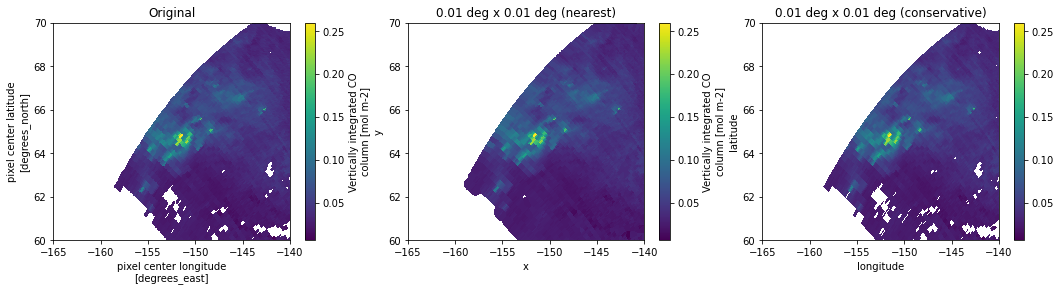

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

scn_tropomi['carbonmonoxide_total_column'].plot(ax=axs[0], x='longitude', y='latitude', xlim=(-165, -140), ylim=(60, 70))
scn_tropomi_alaska_rect['carbonmonoxide_total_column'].plot(ax=axs[1], xlim=(-165, -140), ylim=(60, 70))
co_regrid_xe.where(co_regrid_xe != 0).plot(x='lon', y='lat', cmap='viridis', xlim=(-165, -140), ylim=(60, 70))

axs[0].set_title('Original')
axs[1].set_title('0.01 deg x 0.01 deg (nearest)')
axs[2].set_title('0.01 deg x 0.01 deg (conservative)')

plt.savefig('../figures/nearest_conservative.jpg')

## Curvilinear grids

In [14]:
# you can use `satpy/utils/coord2area_def.py`` to create the area
# python coord2area_def.py alaska_1km laea 60 70 -165 -140 1
alaska_curv = load_area('../scripts/test_areas.yaml', 'alaska_1km')
scn_tropomi_alaska_curv = scn_tropomi.resample(alaska_curv, resampler='nearest')
# scn_tropomi_alaska_curv = scn_tropomi.resample(alaska_curv, resampler='ewa', rows_per_scan=scn_tropomi['nitrogendioxide_tropospheric_column'].shape[0])

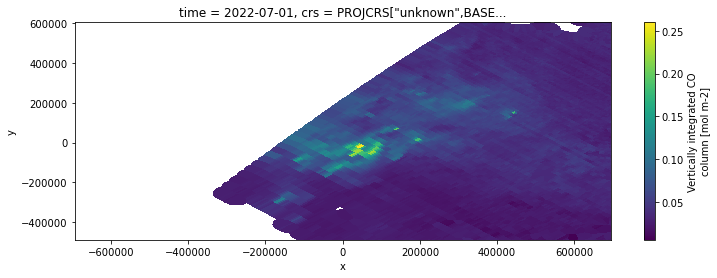

In [15]:
# scn_tropomi_alaska_curv.show('carbonmonoxide_total_column')
scn_tropomi_alaska_curv['carbonmonoxide_total_column'].plot(figsize=(12, 4))

/home/xin/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/home/xin/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


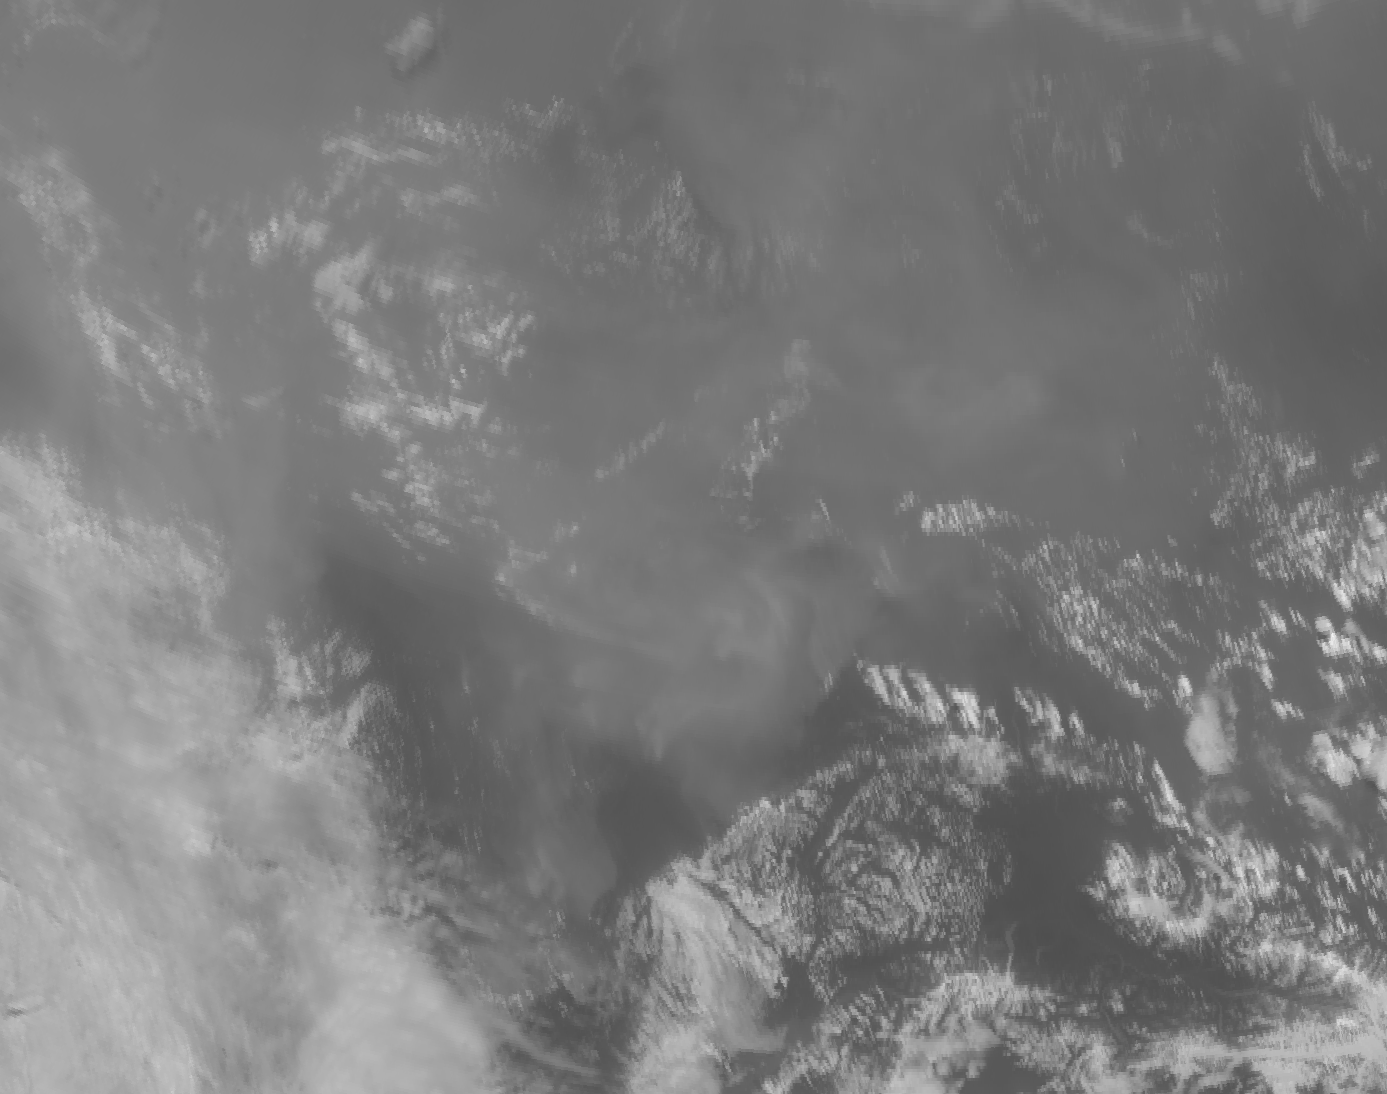

In [16]:
scn_abi_alaska_curv = scn_abi.resample(alaska_curv)
scn_abi_alaska_curv.show('C01')